In [3]:
!pip install pyspark

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyspark: filename=pyspark-3.2.4-py2.py3-none-any.whl size=282040933 sha256=ea5bcf68c837f31d6b3a609ef9e51b7e81d80a84490872ff38cb4c20cca04578
  Stored in directory: c:\users\alber\appdata\local\pip\cache\wheels\7f\b5\ab\6fbc298426a10c8a27065ed80da7241e60146d770f41c80b4d
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, from_json, collect_list, when, concat, lit, from_unixtime
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType, FloatType, LongType, TimestampType
from pyspark.ml.recommendation import ALS, ALSModel

from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics

In [5]:
spark=SparkSession.builder.appName("MovieRec") \
    .config ("spark.sql.shuffle.partitions", "16") \
    .config("spark.driver.maxResultSize","4g") \
    .config ("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()


c:\users\alber\.conda\envs\data-science\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [6]:
credit_schema = StructType([
    StructField("cast", StringType(), True),
    StructField("crew", StringType(), True),
    StructField("id", IntegerType(), True)
])


In [7]:
credits = spark.read.csv("./archive/credits.csv", header=True, schema=credit_schema)

# Create temporary views for the credits DataFrame
credits.createOrReplaceTempView("credits")

In [9]:
credits = spark.read.csv("./archive/credits.csv", header=True, schema=credit_schema)

# Create temporary views for the credits DataFrame
credits.createOrReplaceTempView("credits")
cast_info_schema = StructType([
    StructField("cast_id", IntegerType(), True),
    StructField("character", StringType(), True),
    StructField("gender", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("profile_path", StringType(), True),
    StructField("credit_id", StringType(), True)
])


cast = credits.select("id", explode(from_json("cast", ArrayType(cast_info_schema))).alias("cast_info"))
cast = cast.filter(col("cast_info").isNotNull())

cast.createOrReplaceTempView("casts")

In [10]:

# Extract individual fields from the exploded cast_info struct
cast_res = cast.select("id", 
                   col("cast_info.cast_id").alias("cast_id"), 
                   col("cast_info.character").alias("character"), 
                   col("cast_info.gender").alias("gender"), 
                   col("cast_info.id").alias("actor_id"), 
                   col("cast_info.name").alias("name"), 
                   col("cast_info.profile_path").alias("profile_path"), 
                   col("cast_info.credit_id").alias("credit_id"))


cast_res = cast_res.withColumn("profile_url", concat(lit("https://image.tmdb.org/t/p/w185"), col("profile_path")))
cast_res.show()


+-----+-------+--------------------+------+--------+--------------------+--------------------+--------------------+--------------------+
|   id|cast_id|           character|gender|actor_id|                name|        profile_path|           credit_id|         profile_url|
+-----+-------+--------------------+------+--------+--------------------+--------------------+--------------------+--------------------+
|15602|      2|         Max Goldman|     2|    6837|      Walter Matthau|/xJVkvprOnzP5Zdh5...|52fe466a9251416c7...|https://image.tmd...|
|15602|      3|      John Gustafson|     2|    3151|         Jack Lemmon|/chZmNRYMtqkiDlat...|52fe466a9251416c7...|https://image.tmd...|
|15602|      4|     Ariel Gustafson|     1|   13567|         Ann-Margret|/jx5lTaJ5VXZHYB52...|52fe466a9251416c7...|https://image.tmd...|
|15602|      5|Maria Sophia Cole...|     1|   16757|        Sophia Loren|/emKLhbji1c7BjcA2...|52fe466a9251416c7...|https://image.tmd...|
|15602|      6|   Melanie Gustafson|     

In [11]:
name_counts = cast_res.groupBy("name").count()
name_counts = name_counts.orderBy("count", ascending=False)
name_counts.show()

+-----------------+-----+
|             name|count|
+-----------------+-----+
|     Frank Welker|   37|
|     Grey Griffin|   29|
| Gérard Depardieu|   29|
|   Susan Sarandon|   29|
|      Keith David|   27|
|Donald Sutherland|   26|
|     John Goodman|   25|
| Malcolm McDowell|   25|
|    Robert Duvall|   25|
|     Danny Glover|   24|
|     Alec Baldwin|   24|
|Samuel L. Jackson|   24|
|     Barbara Hale|   24|
|     William Hurt|   24|
|  Whoopi Goldberg|   24|
| David Strathairn|   24|
|    Anthony Quinn|   23|
|  Matthew Lillard|   23|
|       Ned Beatty|   23|
|  Richard Jenkins|   23|
+-----------------+-----+
only showing top 20 rows



In [8]:
crew_info_schema = StructType([
    StructField("credit_id", StringType(), True),
    StructField("department", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("name", StringType(), True),
    StructField("profile_path", StringType(), True)
])


In [9]:
crew = credits.select("id", explode(from_json("crew", ArrayType(crew_info_schema))).alias("crew_info"))
# Select individual attributes from the exploded struct
crew_res = crew.select(
    "id",
    col("crew_info.credit_id").alias("credit_id"),
    col("crew_info.department").alias("department"),
    col("crew_info.id").alias("crew_id"),
    col("crew_info.job").alias("job"),
    col("crew_info.name").alias("name"),
    col("crew_info.profile_path").alias("profile_path")
)
# w185
crew_res = crew_res.withColumn("profile_url", concat(lit("https://image.tmdb.org/t/p/w185"), col("profile_path")))
crew_res.show()

+------+--------------------+----------+-------+------------+-------------------+--------------------+--------------------+
|    id|           credit_id|department|crew_id|         job|               name|        profile_path|         profile_url|
+------+--------------------+----------+-------+------------+-------------------+--------------------+--------------------+
| 16420|5462510ec3a368082...|   Writing|   6210|      Writer|William Shakespeare|/2z4njqosEQM4g26t...|https://image.tmd...|
| 16420|52fe46d29251416c7...| Directing|  56710|    Director|      Oliver Parker|/3qdUN7qhcQn4P3tE...|https://image.tmd...|
| 16420|54625118c3a368081...|   Writing|  56710|  Adaptation|      Oliver Parker|/3qdUN7qhcQn4P3tE...|https://image.tmd...|
| 31174|52fe44669251416c9...| Directing|  33315|    Director|  Richard Loncraine|/j700yY5SyI1EZegF...|https://image.tmd...|
| 31174|546110c3c3a3686f3...|   Writing|   6210|Theatre Play|William Shakespeare|/2z4njqosEQM4g26t...|https://image.tmd...|
| 31174|

In [10]:
name_counts = crew_res.groupBy("name").count()
name_counts = name_counts.orderBy("count", ascending=False)
name_counts.show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|      Georges Méliès|   52|
|William K.L. Dick...|   28|
|         David Lynch|   21|
|        Ere Kokkonen|   20|
|       William Heise|   19|
|          Chang Cheh|   18|
|      Eldar Ryazanov|   17|
|   Frederick Wiseman|   17|
|         Albert Pyun|   16|
|        Chris Marker|   16|
|            Ni Kuang|   15|
|      Norman McLaren|   15|
|       D.W. Griffith|   14|
|       Kenneth Anger|   14|
|    Abbas Kiarostami|   13|
|     Jean-Luc Godard|   13|
|    Kiyoshi Kurosawa|   13|
|     Edward F. Cline|   13|
|       John Lasseter|   13|
|       Stan Brakhage|   13|
+--------------------+-----+
only showing top 20 rows



In [14]:
genre_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
])

movies = spark.read.csv("./archive/movies_metadata.csv", header=True, inferSchema=True)

movie_genres = movies.select("id", explode(from_json("genres", ArrayType(genre_schema))).alias("genre_info"))
movie_genres = movie_genres.filter(col("genre_info").isNotNull())

# Extract individual fields from the exploded genre_info struct
movie_genres = movie_genres.select(
    "id", 
    col("genre_info.id").alias("genre_id"), 
    col("genre_info.name").alias("name")
)
movie_genres.show()


+-----+--------+---------+
|   id|genre_id|     name|
+-----+--------+---------+
|  862|      16|Animation|
|  862|      35|   Comedy|
|  862|   10751|   Family|
| 8844|      12|Adventure|
| 8844|      14|  Fantasy|
| 8844|   10751|   Family|
|15602|   10749|  Romance|
|15602|      35|   Comedy|
|31357|      35|   Comedy|
|31357|      18|    Drama|
|31357|   10749|  Romance|
|11862|      35|   Comedy|
|  949|      28|   Action|
|  949|      80|    Crime|
|  949|      18|    Drama|
|  949|      53| Thriller|
|11860|      35|   Comedy|
|11860|   10749|  Romance|
|45325|      28|   Action|
|45325|      12|Adventure|
+-----+--------+---------+
only showing top 20 rows



In [15]:
genre_counts = movie_genres.groupBy("name").count()
genre_counts.show()

+---------------+-----+
|           name|count|
+---------------+-----+
|         Horror| 4656|
|        Western| 1040|
|         Comedy|13123|
|         Family| 2747|
|        Romance| 6722|
|Science Fiction| 3041|
|    Documentary| 3929|
|        Fantasy| 2308|
|        Foreign| 1620|
|          Music| 1591|
|       Thriller| 7612|
|         Action| 6581|
|          Crime| 4294|
|      Adventure| 3477|
|        History| 1396|
|        Mystery| 2466|
|            War| 1321|
|       TV Movie|  764|
|          Drama|20239|
|      Animation| 1922|
+---------------+-----+
only showing top 20 rows



In [16]:
filter_columns = ['adult', 'budget', 'id', 'imdb_id', 'original_language', 'original_title', 'overview',
                  'popularity', 'poster_path', 'release_date', 'revenue', 'runtime', 'status', 'tagline',
                  'title', 'vote_average', 'vote_count']

filtered_movies = movies.select(filter_columns)
filtered_movies = filtered_movies.withColumn("tagline", when(col("tagline").isNull(), "N/A").otherwise(col("tagline")))
filtered_movies = filtered_movies.dropna()

filtered_movies = filtered_movies.withColumn("poster_url", concat(lit("https://image.tmdb.org/t/p/w500"), col("poster_path")))

filtered_movies.show()

+-----+--------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----------------+--------------------+
|adult|  budget|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|        release_date|             revenue|             runtime|  status|             tagline|               title|        vote_average|       vote_count|          poster_url|
+-----+--------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----------------+--------------------+
|False|30000000|  862|tt0114709|               en|           Toy Story|Led by Woody, And...| 21.946943|

In [17]:
filtered_movies.select("poster_url").tail(3)

[Row(poster_url='https://image.tmdb.org/t/p/w500/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg'),
 Row(poster_url='https://image.tmdb.org/t/p/w500/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg'),
 Row(poster_url='https://image.tmdb.org/t/p/w500/s5UkZt6NTsrS7ZF0Rh8nzupRlIU.jpg')]

In [18]:
ratings_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

ratings = spark.read.csv("./archive/ratings.csv", header=True, schema = ratings_schema)

ratings.show(truncate=True)


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
|     1|   1968|   4.0|1425942148|
|     1|   2762|   4.5|1425941300|
|     1|   2918|   5.0|1425941593|
|     1|   2959|   4.0|1425941601|
|     1|   4226|   4.0|1425942228|
|     1|   4878|   5.0|1425941434|
|     1|   5577|   5.0|1425941397|
|     1|  33794|   4.0|1425942005|
|     1|  54503|   3.5|1425941313|
|     1|  58559|   4.0|1425942007|
|     1|  59315|   5.0|1425941502|
|     1|  68358|   5.0|1425941464|
|     1|  69844|   5.0|1425942139|
|     1|  73017|   5.0|1425942699|
|     1|  81834|   5.0|1425942133|
+------+-------+------+----------+
only showing top 20 rows



In [19]:

# Convert the timestamp column to datetime
ratings_spark = ratings.withColumn("datetime", from_unixtime(col("timestamp")).cast(TimestampType()))


In [20]:
ratings_spark.show()

+------+-------+------+----------+-------------------+
|userId|movieId|rating| timestamp|           datetime|
+------+-------+------+----------+-------------------+
|     1|    110|   1.0|1425941529|2015-03-10 04:37:09|
|     1|    147|   4.5|1425942435|2015-03-10 04:52:15|
|     1|    858|   5.0|1425941523|2015-03-10 04:37:03|
|     1|   1221|   5.0|1425941546|2015-03-10 04:37:26|
|     1|   1246|   5.0|1425941556|2015-03-10 04:37:36|
|     1|   1968|   4.0|1425942148|2015-03-10 04:47:28|
|     1|   2762|   4.5|1425941300|2015-03-10 04:33:20|
|     1|   2918|   5.0|1425941593|2015-03-10 04:38:13|
|     1|   2959|   4.0|1425941601|2015-03-10 04:38:21|
|     1|   4226|   4.0|1425942228|2015-03-10 04:48:48|
|     1|   4878|   5.0|1425941434|2015-03-10 04:35:34|
|     1|   5577|   5.0|1425941397|2015-03-10 04:34:57|
|     1|  33794|   4.0|1425942005|2015-03-10 04:45:05|
|     1|  54503|   3.5|1425941313|2015-03-10 04:33:33|
|     1|  58559|   4.0|1425942007|2015-03-10 04:45:07|
|     1|  

In [60]:
ratings_spark.toPandas().to_csv("filtered_ratings.csv")
filtered_movies.toPandas().to_csv("filtered_movies.csv")
movie_genres.toPandas().to_csv("filtered_genres.csv")

In [21]:
from pyspark.sql.functions import col, desc
from pyspark.sql.window import Window
# Extract the year from the release_date column
movies_spark = movies.withColumn("release_year", col("release_date").substr(1, 4).cast("int"))

# Determine the latest year in the dataset
latest_year = movies_spark.selectExpr("max(release_year)").collect()[0][0]

# Calculate a threshold year for considering "new releases"
threshold_year = latest_year - 2  # For example, consider movies released in the last 2 years

# Filter movies released in the threshold year or later
new_releases = movies_spark.filter(col("release_year") >= threshold_year)

# Calculate user-specific ratings count using window function
window_spec = Window.partitionBy("userId").orderBy(desc("timestamp"))


In [22]:
# New Releases Recommendations:
from pyspark.sql.functions import col, desc, count

start_user_id = 1 
end_user_id = 100   
latest_year = movies_spark.selectExpr("max(release_year)").collect()[0][0]

threshold_year = latest_year - 7

new_releases = movies_spark.filter(col("release_year") >= threshold_year)
window_spec = Window.partitionBy("userId").orderBy(desc("timestamp"))
user_ratings_count = ratings_spark.withColumn("ratings_count", count("userId").over(window_spec))
active_users = user_ratings_count.filter(col("ratings_count") >= 1)
active_users = active_users.filter(col("userId").between(start_user_id, end_user_id))
active_users_with_new_releases = active_users.join(new_releases,  on=active_users["movieId"] == new_releases["id"], how="inner")
active_users_with_new_releases.select("userId", "movieId", "title", "release_date").distinct().show(truncate=False)


+------+-------+--------------------+------------+
|userId|movieId|title               |release_date|
+------+-------+--------------------+------------+
|32    |97938  |Heart of the Country|2013-08-19  |
|38    |97938  |Heart of the Country|2013-08-19  |
|70    |97938  |Heart of the Country|2013-08-19  |
|82    |97938  |Heart of the Country|2013-08-19  |
+------+-------+--------------------+------------+



In [23]:

from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col


In [75]:
(training, test) = ratings_spark.randomSplit([0.8, 0.2], seed=42069)

als = ALS(
          rank=30,
          maxIter=4, 
          regParam=0.1,
          userCol='userId', 
          itemCol='movieId', 
          ratingCol='rating',
          coldStartStrategy='drop',
          implicitPrefs=False
)

model = als.fit(training)
predictions = model.transform(test)


In [26]:
# RegressionEvaluator
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
variance_evaluator = RegressionEvaluator(metricName="var", labelCol="rating", predictionCol="prediction")

# Calculating metrics
rmse = rmse_evaluator.evaluate(predictions)
mse = mse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
variance = variance_evaluator.evaluate(predictions)

print("RMSE::", rmse)
print("MSE::", mse)
print("R-squared::", r2)
print("MAE::", mae)
print("Explained Variance::", variance)

RMSE: 0.8354691847242828
MSE: 0.6980087586238577
R-squared: 0.3850756227538704
MAE: 0.6561898011680688
Explained Variance: 0.43460653059256626


In [76]:
model.recommendForAllUsers(1).show(5)


c:\users\alber\.conda\envs\data-science\lib\site-packages\pyspark\sql\context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    12|[{138580, 5.74117...|
|    18|[{169924, 6.807972}]|
|    38| [{79348, 5.606722}]|
|    67|[{173939, 6.09430...|
|    70|[{173721, 5.847862}]|
+------+--------------------+
only showing top 5 rows



In [29]:
from matplotlib import pyplot as plt

In [58]:
actual_ratings = predictions.select('rating').rdd.map(lambda row: row[0]).collect()
predicted_ratings = predictions.select('prediction').rdd.map(lambda row: row[0]).collect()


In [33]:
actual_ratings

[4.0,
 5.0,
 5.0,
 1.0,
 5.0,
 5.0,
 5.0,
 3.0,
 4.0,
 3.0,
 5.0,
 5.0,
 5.0,
 3.0,
 4.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 3.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 3.0,
 1.0,
 4.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 3.0,
 3.0,
 4.0,
 1.0,
 5.0,
 3.0,
 4.0,
 4.0,
 3.0,
 5.0,
 3.5,
 3.5,
 4.0,
 3.5,
 4.0,
 3.0,
 4.5,
 3.5,
 4.5,
 4.5,
 3.0,
 3.5,
 4.5,
 5.0,
 1.5,
 3.0,
 3.5,
 3.0,
 5.0,
 5.0,
 2.5,
 3.0,
 0.5,
 5.0,
 3.0,
 5.0,
 5.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 3.0,
 3.0,
 4.0,
 4.5,
 2.5,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 0.5,
 4.0,
 3.0,
 5.0,
 3.5,
 0.5,
 4.0,
 5.0,
 5.0,
 4.0,
 4.5,
 5.0,
 5.0,
 4.0,
 4.0,
 4.5,
 4.0,
 4.0,
 3.0,
 3.0,
 1.5,
 5.0,
 5.0,
 3.0,
 5.0,
 5.0,
 4.0,
 4.0,
 5.0,
 5.0,
 4.5,
 4.5,
 4.5,
 5.0,
 4.5,
 5.0,
 4.0,
 5.0,
 3.5,
 2.0,
 4.0,
 5.0,
 3.0,
 4.0,
 3.0,
 5.0,
 3.0,
 1.0,
 4.0,
 2.0,
 5.0,
 4.0,
 5.0,
 4.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 3.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 5.0,
 3.0,
 3.0,
 3.0,
 4.0,
 3.0,
 3.0,
 4.0,
 4.0,
 2.0,
 5.0

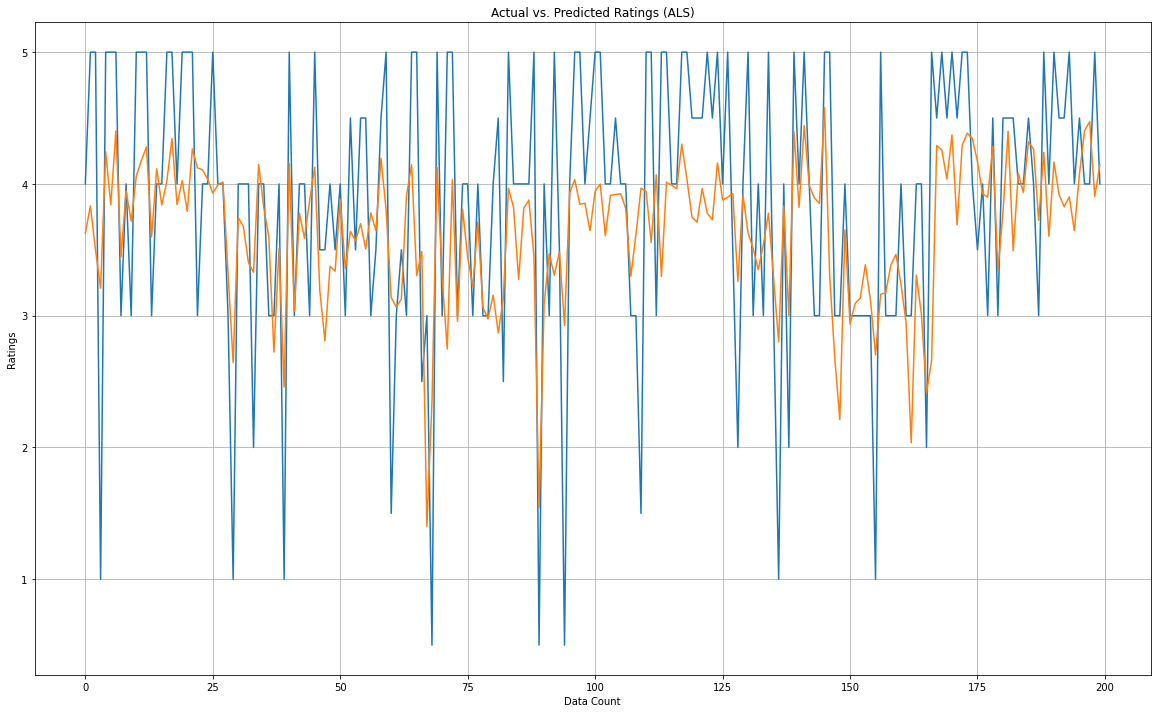

In [57]:
plt.figure(figsize=(20, 12))
plt.plot(actual_ratings[0:200])
plt.plot(predicted_ratings[0:200])
plt.xlabel('Data Count')
plt.ylabel('Ratings')
plt.title('Actual vs. Predicted Ratings (ALS)')
plt.grid(True)

In [68]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

movie_avg_ratings = ratings_spark.groupBy("movieId").agg({"rating": "avg"})

feature_columns = ["avg(rating)"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(movie_avg_ratings)

kmeans = KMeans(k=20, seed=42069) 

model = kmeans.fit(assembled_data)

clustered_data = model.transform(assembled_data)

clustered_data.select("movieId", "features", "prediction").show()

+-------+--------------------+----------+
|movieId|            features|prediction|
+-------+--------------------+----------+
|  58559| [4.182070707070707]|         9|
|   1092|[3.3524774774774775]|         8|
|   1911| [2.671553913645809]|        10|
|   2716| [3.747240455655962]|         3|
|   2163|[2.5010378827192525]|        12|
|    585|[2.6114362899594776]|        10|
|    784|[2.7018389048822042]|        10|
|    912|[4.2143927037912325]|         9|
|   1405|[2.9223770809136664]|         4|
|   1591|[2.6416020262782967]|        10|
|   3082|[3.2011004784688994]|        19|
|   3175| [3.586550320670942]|        15|
|   3671|[3.8588944642279053]|         7|
|   4366| [3.268490514160022]|        19|
|   5036|[3.0758196721311477]|        17|
|   4027|[3.8738065587380657]|         7|
|   5502| [3.249963246104087]|        19|
|   5902| [3.834838594294912]|         7|
|   4995|  [3.95701895277867]|         0|
|  45442|[2.6754716981132076]|        10|
+-------+--------------------+----

In [69]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(clustered_data)



In [70]:
wcss = model.summary.trainingCost

In [71]:
silhouette_score, wcss

(0.7510329086309903, 130.87839110396888)

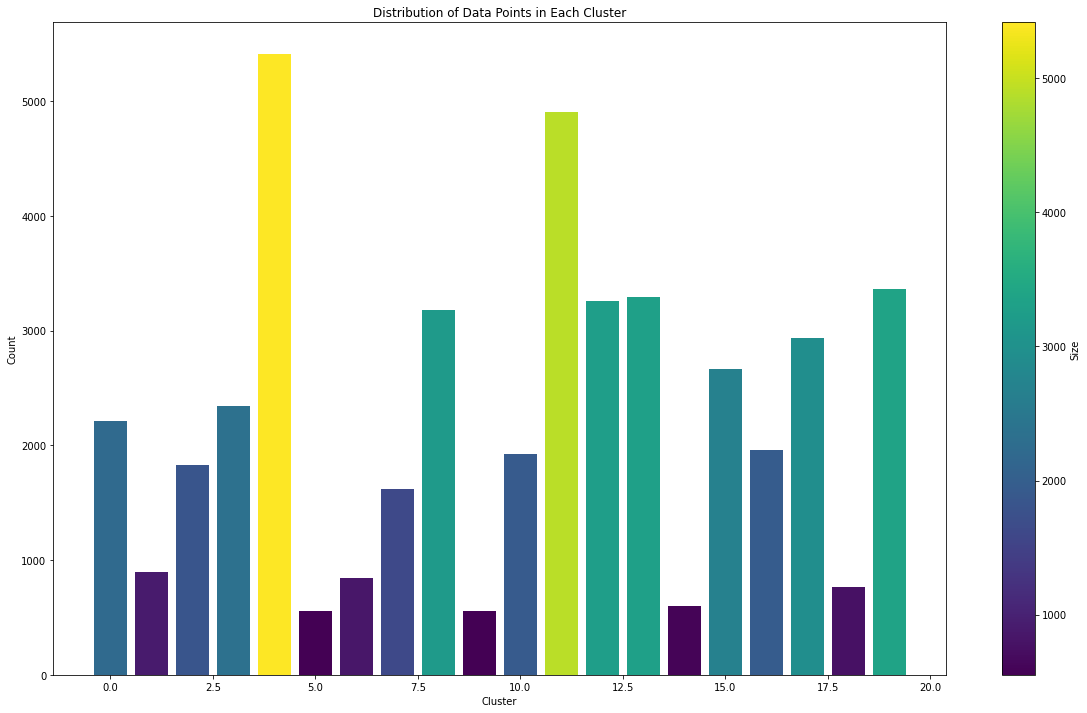

In [73]:
import numpy as np

cluster_counts = clustered_data.groupBy("prediction").count().orderBy("prediction").toPandas()

cmap = plt.get_cmap('viridis')
normalize = plt.Normalize(vmin=cluster_counts["count"].min(), vmax=cluster_counts["count"].max())

fig, ax = plt.subplots(figsize=(20, 12))

bars = ax.bar(cluster_counts["prediction"], cluster_counts["count"], color=cmap(normalize(cluster_counts["count"])))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Size")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Distribution of Data Points in Each Cluster")

plt.show()